# Average energy for each interaction type

### Classes and functions

In [40]:
from __future__ import print_function, division
import sys
sys.path.append('../src')
sys.path.append('../script')

import numpy as np
import math
import time
import torch
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergyOpt, LocalEnergy
from my_script import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer, normalize
import matplotlib.pyplot as plt
# plt.style.use('bmh')
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from LocalEnergyVct import assign_thetatype, assign_phitype

from matplotlib import rc
plt.style.use('default')
plt.rcParams["font.family"] = "serif"
rc('text.latex', preamble=r'\usepackage{cmbright}')

In [2]:
def extract_bonds(features,lengths):
    
    btypes = []
    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        btype = features[i,:lengths[i,6],6].squeeze().long().view(-1,3)
        btype[:,:2] = (btype[:,:2]/3).long()
        btype[:,2] -= 1    
        btypes.append(btype)
        
    return btypes


def bonds_energy(coords, bonds, bond_type):
    
    a1 = bonds[:,0]
    a2 = bonds[:,1]
    idx = bonds[:,2]
    d = coords[a1,:]-coords[a2,:]
    d = torch.linalg.norm(d, dim=1)
    energy = bond_type[idx,0]*(d-bond_type[idx,1])**2
    
    return energy


def create_bondmatrix_line(coords, bonds, bond_type):
    
    energy = bonds_energy(coords, bonds, bond_type)
    bdict = {key: [] for key in np.arange(0,11)}
    for i,en in enumerate(energy):
        key = bonds[i,2].item()
        bdict[key].append(en)
    
    matrix_line = torch.zeros(11)
    for j in bdict.keys():
        matrix_line[j] = sum(bdict[j])/len(bdict[j]) if len(bdict[j]) != 0 else 0
        
    return matrix_line

# ------------------------------------------------------------------------------------

def extract_angles(features,lengths):
    
    atypes = []
    thetas = []

    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        atype = features[i,:lengths[i,7],7].squeeze().long().view(-1,4)
        atype[:,:3] = (atype[:,:3]/3).long()
        atype[:,3] -= 1    
        theta = assign_thetatype(atom,atype[:,0],atype[:,1],atype[:,2])
        atypes.append(atype)
        thetas.append(theta)
        
    return atypes, thetas


def angles_energy(thetatype, coords, angles, angle_type, pars):

    a1 = angles[:,0]
    a2 = angles[:,1]
    a3 = angles[:,2]
    idx = angles[:,3]

    rij = coords[a1,:] - coords[a2,:]
    rkj = coords[a3, :] - coords[a2, :]
    an = torch.acos((rij*rkj).sum(dim=1) / (torch.linalg.norm(rij, dim=1) * torch.linalg.norm(rkj, dim=1)))
    energy = pars[thetatype+1] * angle_type[idx, 0] * (an - angle_type[idx, 1])**2

    return energy


def create_anglematrix_line(thetatype, coords, angles, angle_type, pars):
    
    energy = angles_energy(thetatype, coords, angles, angle_type, pars)
    adict = {key: [] for key in np.arange(0,12)}
    for i,en in enumerate(energy):
        key = angles[i,3].item()
        adict[key].append(en)
    
    matrix_line = torch.zeros(12)
    for j in adict.keys():
        matrix_line[j] = sum(adict[j])/len(adict[j]) if len(adict[j]) != 0 else 0
        
    return matrix_line


# ------------------------------------------------------------------------------------

def extract_torsions(features,lengths):
    
    ttypes = []
    phis = []

    for i in range(len(features)):
        atom = features[i,:lengths[i,0],0].squeeze().long()    
        ttype = features[i,:lengths[i,8],8].squeeze().long().view(-1,5)
        ttype[:,:4] = (ttype[:,:4]/3).long()
        ttype[:,4] -= 1    
        phi = assign_phitype(atom,ttype[:,0],ttype[:,1],ttype[:,2],ttype[:,3])
        ttypes.append(ttype)
        phis.append(phi)
        
    return ttypes, phis


def torsions_energy(phitype, coords, tors, tors_type, mult, pars):

    a1 = tors[:,0]
    a2 = tors[:,1]
    a3 = tors[:,2]
    a4 = tors[:,3]
    idx = tors[:,4]

    rij = coords[a1,:] - coords[a2,:]
    rkj = coords[a3, :] - coords[a2, :]
    rkl = coords[a3, :] - coords[a4, :]
    nj = torch.linalg.cross(rij, rkj, dim=1)
    nj = nj / torch.linalg.norm(nj, dim=1).unsqueeze(1).expand(-1,3)
    nk = torch.linalg.cross(rkl, rkj, dim=1)
    nk = nk / torch.linalg.norm(nk,dim=1).unsqueeze(1).expand(-1,3)
    phi = torch.acos((nj*nk).sum(dim=1))
    phi = math.pi - phi*torch.sign((rkj*torch.linalg.cross(nk, nj, dim=1)).sum(dim=1))
    energy = pars[28+phitype] * tors_type[idx, 0] * (1+torch.cos(mult[idx]*phi - tors_type[idx, 1]))
    
    return energy


def create_torsionmatrix_line(phitype, coords, tors, tors_type, mult, pars):
    
    energy = torsions_energy(phitype, coords, tors, tors_type, mult, pars)
    tdict = {key: [] for key in np.arange(0,25)}
    for i,en in enumerate(energy):
        key = tors[i,4].item()
        tdict[key].append(en)
    
    matrix_line = torch.zeros(25)
    for j in tdict.keys():
        matrix_line[j] = sum(tdict[j])/len(tdict[j]) if len(tdict[j]) != 0 else 0
        
    return matrix_line

# Matrix representations

To visualize how the different terms affect the total energy, we want to construct matrices for bonds, angles and torsions, where each row corresponds to a sequence, while each column identifies a type of interaction, with coupling constant and equilibrium distance. The elements are the average energy of that type, for each specific sequence.

The idea is to check if some type of interactions are give a contribution that is sensibly higher with respect to others

In [3]:
dataset = RNASeqDataset().dataset
features = dataset['features']
lengths = dataset['lengths']
print(features.shape, lengths.shape)

model = LocalEnergyOpt()
model.load_state_dict(torch.load("../results/Results_fixedLR/initial_values_sameorder.pth"))
# model.load_state_dict(torch.load("data/Results/300_b16_e4_Aso.pth"))

bond_pars = model.bond_type.data
angle_pars = model.angle_type.data
torsion_pars = model.tor_type.data
mult = model.multiplicity.data
dat_pars = model.opt_pars.data

coords = [features[i,:lengths[i,5],5].squeeze().view(-1,3) for i in range(len(features))]
atoms = [features[i,:lengths[i,0],0].squeeze().long() for i in range(len(features))]
bonds_amber = features[:,0,9].squeeze()
angles_amber = features[:,1,9].squeeze()
torsions_amber = features[:,2,9].squeeze()

bmean = bonds_amber.mean()
amean = angles_amber.mean()
tmean = torsions_amber.mean()

torch.Size([1635, 445, 10]) torch.Size([1635, 10])


## Bond energy

In [6]:
bonds = extract_bonds(features,lengths)
bond_matrix = torch.zeros(len(features),11)
for i in range(len(features)):
    bond_matrix[i] = create_bondmatrix_line(coords[i], bonds[i], bond_pars)

In [7]:
print(bond_matrix[:5])

tensor([[3.9479e-03, 8.6600e-04, 2.9793e-03, 7.9475e-04, 2.0246e-03, 0.0000e+00,
         2.4243e-03, 4.6806e-03, 7.5794e-04, 4.5047e-04, 1.3660e-04],
        [7.1793e-03, 3.6411e-04, 3.2364e-03, 1.6334e-03, 3.1759e-03, 0.0000e+00,
         2.4522e-03, 4.9877e-03, 5.2894e-04, 3.8353e-04, 1.7966e-04],
        [2.5066e-02, 3.3564e-04, 3.7503e-03, 0.0000e+00, 2.6516e-03, 3.5145e-03,
         2.4581e-03, 0.0000e+00, 7.6920e-04, 9.0415e-04, 8.8490e-05],
        [6.1425e-03, 1.3363e-03, 3.0830e-03, 8.5784e-04, 2.6519e-03, 1.2909e-03,
         2.4408e-03, 4.4820e-03, 6.7063e-04, 3.1735e-04, 1.5164e-04],
        [5.8868e-03, 3.2994e-04, 2.9156e-03, 0.0000e+00, 3.3063e-03, 1.7850e-03,
         2.4607e-03, 0.0000e+00, 5.5381e-04, 3.5233e-04, 1.8679e-04]])


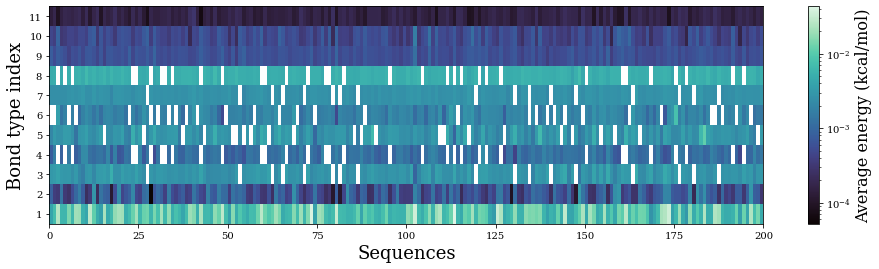

In [9]:
fig = plt.figure(figsize=(16,4))
data = bond_matrix[:200].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences",fontsize=18)
plt.ylabel("Bond type index",fontsize=18)
locs, labels = plt.yticks()
locs = np.arange(11)+0.5
plt.yticks(locs, np.arange(1,12))
cbar.ax.set_ylabel("Average energy (kcal/mol)", rotation=90, fontsize=16)
plt.savefig('../Images/bond_matrix.png',bbox_inches='tight',dpi=100)
plt.show()

## Angle energy

In [10]:
angle_matrix = torch.zeros(len(features),12)
angles, thetas = extract_angles(features, lengths)
for i in range(len(features)):
    angle_matrix[i] = create_anglematrix_line(thetas[i], coords[i], angles[i], angle_pars, dat_pars)

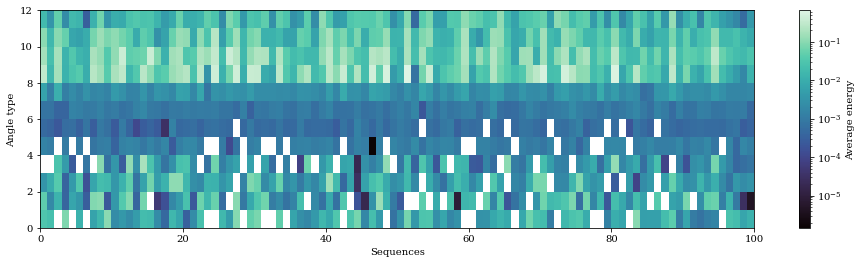

In [11]:
fig = plt.figure(figsize=(16,4))
data = angle_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Angle type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

## Torsion energy

In [12]:
torsions, phis = extract_torsions(features,lengths)
torsion_matrix = torch.zeros(len(features),25)
for i in range(len(features)):
    torsion_matrix[i] = create_torsionmatrix_line(phis[i], coords[i], torsions[i], torsion_pars, mult, dat_pars)

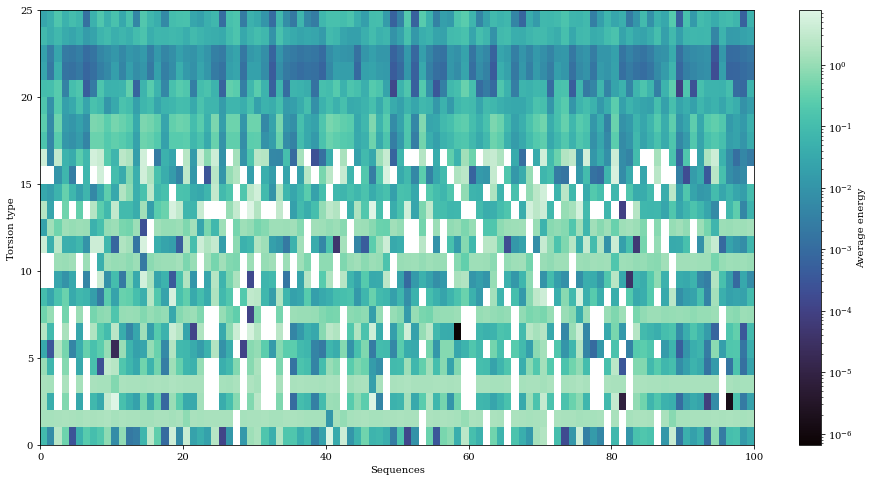

In [13]:
fig = plt.figure(figsize=(16,8))
data = torsion_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Torsion type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

## PCA


### Bonds

[5.60230020e-01 2.31039245e-01 1.06536068e-01 5.12295517e-02
 2.08181354e-02 1.19854031e-02 7.60961950e-03 6.84032814e-03
 3.00494691e-03 5.58198344e-04 1.48484146e-04]


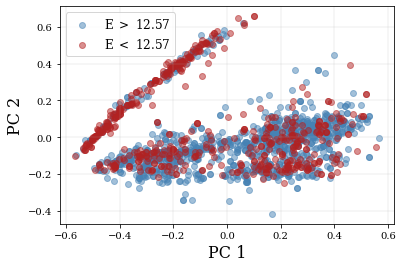

In [15]:
bpca = decomposition.PCA()
nbond_matrix = normalize(bond_matrix, axis=1)
bpca.fit(nbond_matrix)
bonds_pca = bpca.transform(nbond_matrix)
fig, ax = plt.subplots()
ax.scatter(bonds_pca[bonds_amber<13,0], bonds_pca[bonds_amber<13,1], 
           alpha=0.5, color = 'steelblue', label = 'E $>$ 12.57')
ax.scatter(bonds_pca[bonds_amber>=13,0], bonds_pca[bonds_amber>=13,1], 
           alpha=0.5, color='firebrick', label = 'E $<$ 12.57')
ax.grid(linewidth=0.2)
ax.legend(fontsize=12)

'''''
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])  # (xcoord, ycoord, xdim, ydim)
axins.scatter(bonds_pca[bonds_amber<bmean,0], bonds_pca[bonds_amber<bmean,1], alpha=0.5)
axins.scatter(bonds_pca[bonds_amber>bmean,0], bonds_pca[bonds_amber>bmean,1], alpha=0.3)
axins.set_xlim(-0.03,0.05)
axins.set_ylim(-0.02,0.03)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")
'''''

ax.set_xlabel("PC 1", fontsize = 16)
ax.set_ylabel("PC 2", fontsize = 16)
plt.savefig('../Images/PCA_bonds.png',bbox_inches='tight',dpi=100)

print(bpca.explained_variance_ratio_)

### Angles

[4.02540857e-01 1.74888656e-01 9.04205190e-02 8.85224836e-02
 8.28451403e-02 7.36388845e-02 6.40783709e-02 1.90369558e-02
 2.98802689e-03 7.39137269e-04 2.24229126e-04 7.67395397e-05]


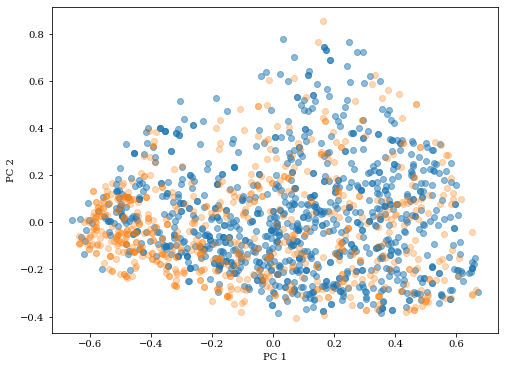

In [16]:
apca = decomposition.PCA()
nangle_matrix = normalize(angle_matrix, axis=1)
apca.fit(nangle_matrix)
angles_pca = apca.transform(nangle_matrix)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(angles_pca[angles_amber<amean,0], angles_pca[angles_amber<amean,1], alpha=0.5)
ax.scatter(angles_pca[angles_amber>=amean,0], angles_pca[angles_amber>=amean,1], alpha=0.3)

'''''
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])  
axins.scatter(angles_pca[angles_amber<amean,0], angles_pca[angles_amber<amean,1], alpha=0.5)
axins.scatter(angles_pca[angles_amber>=amean,0], angles_pca[angles_amber>=amean,1], alpha=0.3)
axins.set_xlim(-0.25,0.2)
axins.set_ylim(-0.1,0.1)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")
'''''

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(apca.explained_variance_ratio_)

### Torsions

[4.02540857e-01 1.74888656e-01 9.04205190e-02 8.85224836e-02
 8.28451403e-02 7.36388845e-02 6.40783709e-02 1.90369558e-02
 2.98802689e-03 7.39137269e-04 2.24229126e-04 7.67395397e-05]


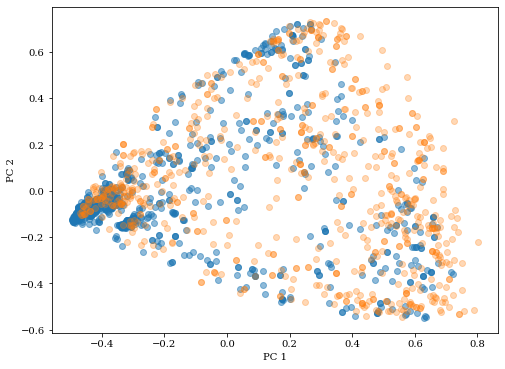

In [17]:
tpca = decomposition.PCA()
ntorsion_matrix = normalize(torsion_matrix, axis=1)
tpca.fit(ntorsion_matrix)
torsions_pca = tpca.transform(ntorsion_matrix)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(torsions_pca[torsions_amber<tmean,0], torsions_pca[torsions_amber<tmean,1], alpha=0.5)
ax.scatter(torsions_pca[torsions_amber>=tmean,0], torsions_pca[torsions_amber>=tmean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(apca.explained_variance_ratio_)

## Projection of data with optimized parameters on input PCA

In [18]:
model = LocalEnergy()
model.load_state_dict(torch.load("../results/ResultsReport/400_b4_free_optimization.pth"))

out_bond_pars = torch.cat((model.couplings.bonds.data.view(-1,1),model.equil.bonds.data.view(-1,1)),dim=1)
out_angle_pars = torch.cat((model.couplings.bonds.data.view(-1,1),model.equil.bonds.data.view(-1,1)),dim=1)
out_torsion_pars = torch.cat((model.couplings.torsions.data.view(-1,1),model.equil.torsions.data.view(-1,1)),dim=1)
out_dat_pars = model.opt_pars.data

In [19]:
out_bond_matrix = torch.zeros(len(features),11)
for i in range(len(features)):
    out_bond_matrix[i] = create_bondmatrix_line(coords[i], bonds[i], out_bond_pars)

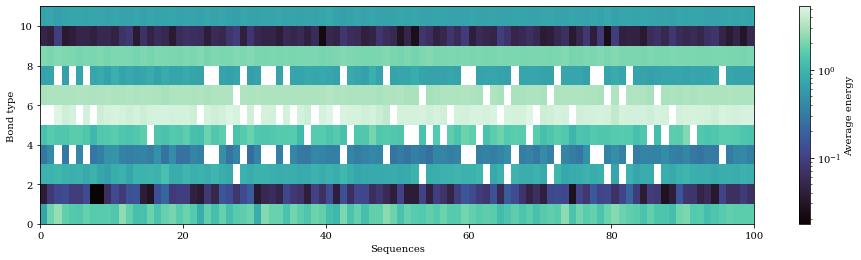

In [20]:
fig = plt.figure(figsize=(16,4))
data = out_bond_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Bond type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[5.60230020e-01 2.31039245e-01 1.06536068e-01 5.12295517e-02
 2.08181354e-02 1.19854031e-02 7.60961950e-03 6.84032814e-03
 3.00494691e-03 5.58198344e-04 1.48484146e-04]


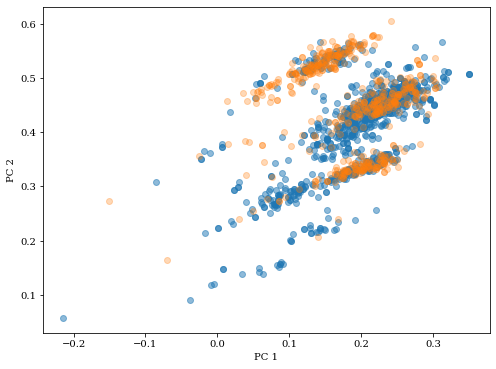

In [21]:
out_bonds_pca = bpca.transform(normalize(out_bond_matrix))
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out_bonds_pca[bonds_amber<13,0], out_bonds_pca[bonds_amber<13,1], alpha=0.5)
ax.scatter(out_bonds_pca[bonds_amber>=13,0], out_bonds_pca[bonds_amber>=13,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(bpca.explained_variance_ratio_)

In [22]:
out_angle_matrix = torch.zeros(len(features),12)
for i in range(len(features)):
    out_angle_matrix[i] = create_anglematrix_line(thetas[i], coords[i], angles[i], out_angle_pars, out_dat_pars)

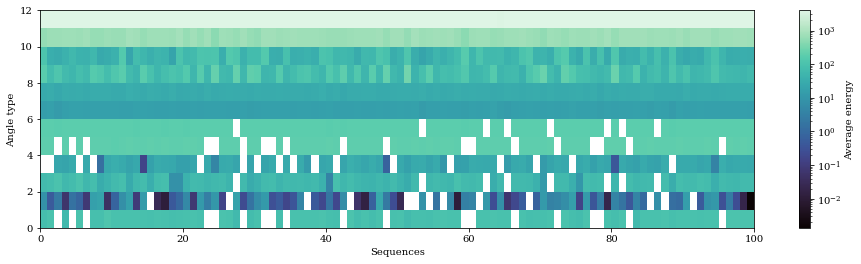

In [23]:
fig = plt.figure(figsize=(16,4))
data = out_angle_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Angle type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[4.02540857e-01 1.74888656e-01 9.04205190e-02 8.85224836e-02
 8.28451403e-02 7.36388845e-02 6.40783709e-02 1.90369558e-02
 2.98802689e-03 7.39137269e-04 2.24229126e-04 7.67395397e-05]


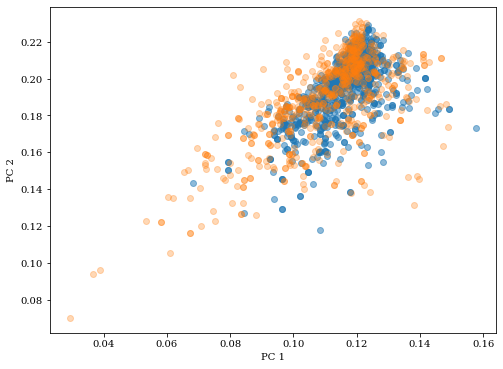

In [24]:
out_angles_pca = apca.transform(normalize(out_angle_matrix))
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out_angles_pca[angles_amber<amean,0], out_angles_pca[angles_amber<amean,1], alpha=0.5)
ax.scatter(out_angles_pca[angles_amber>=amean,0], out_angles_pca[angles_amber>=amean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(apca.explained_variance_ratio_)

In [25]:
out_torsion_matrix = torch.zeros(len(features),25)
for i in range(len(features)):
    out_torsion_matrix[i] = create_torsionmatrix_line(phis[i], coords[i], torsions[i],
                                                      out_torsion_pars, mult, out_dat_pars)

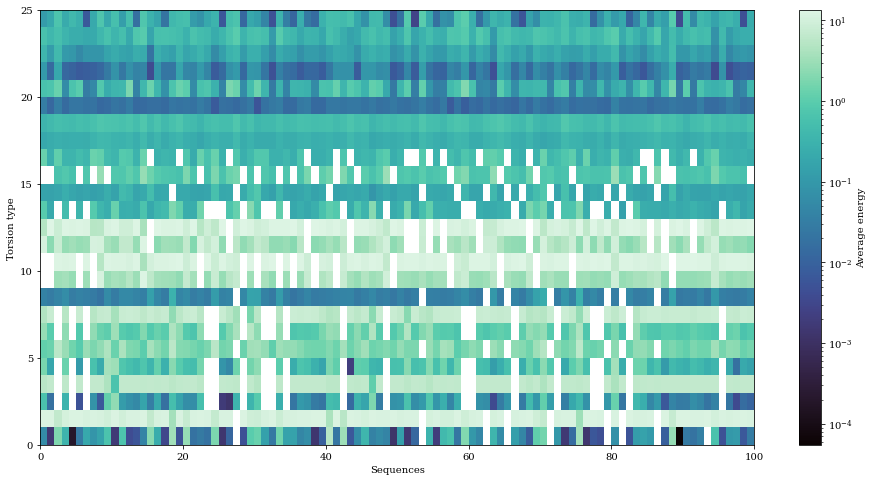

In [26]:
fig = plt.figure(figsize=(16,8))
data = out_torsion_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Torsion type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[3.12470931e-01 1.65464562e-01 1.25662726e-01 9.32908511e-02
 8.63306201e-02 5.11038323e-02 3.92082687e-02 3.23113436e-02
 2.57040873e-02 1.81223159e-02 1.07078360e-02 8.63315787e-03
 8.20572768e-03 6.96581963e-03 5.40376923e-03 4.33315369e-03
 3.62960862e-03 9.81231114e-04 8.67712648e-04 2.51651025e-04
 1.75011375e-04 1.51409452e-04 1.40282900e-05 1.02148573e-05
 1.30918520e-07]


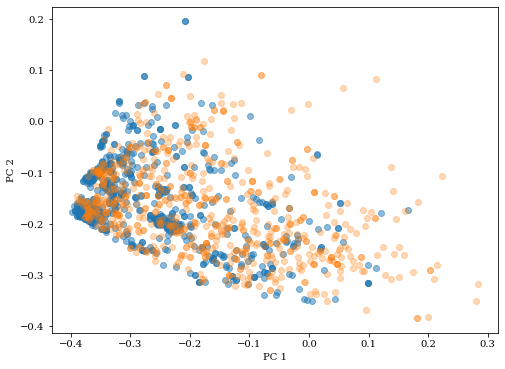

In [27]:
out_torsions_pca = tpca.transform(normalize(out_torsion_matrix))
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out_torsions_pca[torsions_amber<tmean,0], out_torsions_pca[torsions_amber<tmean,1], alpha=0.5)
ax.scatter(out_torsions_pca[torsions_amber>=tmean,0], out_torsions_pca[torsions_amber>=tmean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(tpca.explained_variance_ratio_)

## Projection of data with optimized parameters on input PCA with psgd

In [30]:
model_psgd = LocalEnergy()
model_psgd.load_state_dict(torch.load('../results/NewResults/200_b1_e3e3e4_psgd_sdeq.pth'))

out_bond_pars = torch.cat((model_psgd.couplings.bonds.data.view(-1,1),model_psgd.equil.bonds.data.view(-1,1)),dim=1)
out_angle_pars = torch.cat((model_psgd.couplings.angles.data.view(-1,1),model_psgd.equil.angles.data.view(-1,1)),dim=1)
out_torsion_pars = torch.cat((model_psgd.couplings.torsions.data.view(-1,1),model_psgd.equil.torsions.data.view(-1,1)),dim=1)
out_dat_pars = model.opt_pars.data

In [31]:
out_bond_matrix = torch.zeros(len(features),11)
for i in range(len(features)):
    out_bond_matrix[i] = create_bondmatrix_line(coords[i], bonds[i], out_bond_pars)

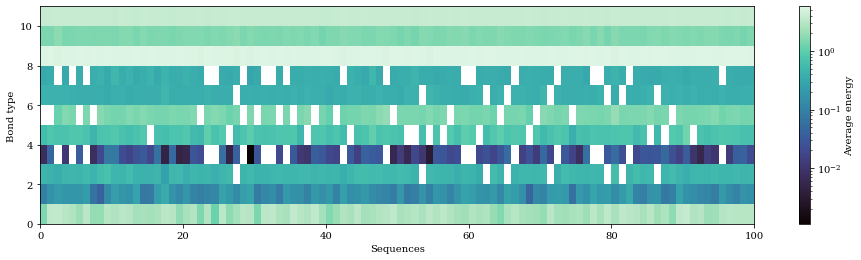

In [32]:
fig = plt.figure(figsize=(16,4))
data = out_bond_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Bond type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[5.60230020e-01 2.31039245e-01 1.06536068e-01 5.12295517e-02
 2.08181354e-02 1.19854031e-02 7.60961950e-03 6.84032814e-03
 3.00494691e-03 5.58198344e-04 1.48484146e-04]


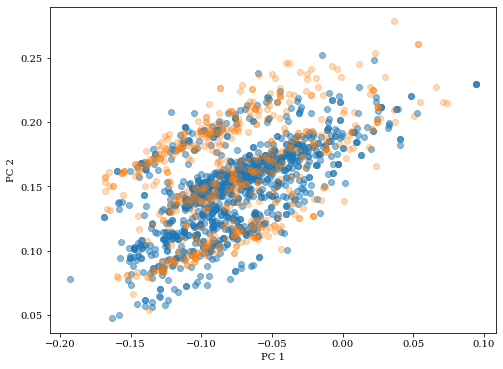

In [33]:
out_bonds_pca = bpca.transform(normalize(out_bond_matrix))
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out_bonds_pca[bonds_amber<13,0], out_bonds_pca[bonds_amber<13,1], alpha=0.5)
ax.scatter(out_bonds_pca[bonds_amber>=13,0], out_bonds_pca[bonds_amber>=13,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(bpca.explained_variance_ratio_)

In [34]:
out_angle_matrix = torch.zeros(len(features),12)
for i in range(len(features)):
    out_angle_matrix[i] = create_anglematrix_line(thetas[i], coords[i], angles[i], out_angle_pars, out_dat_pars)

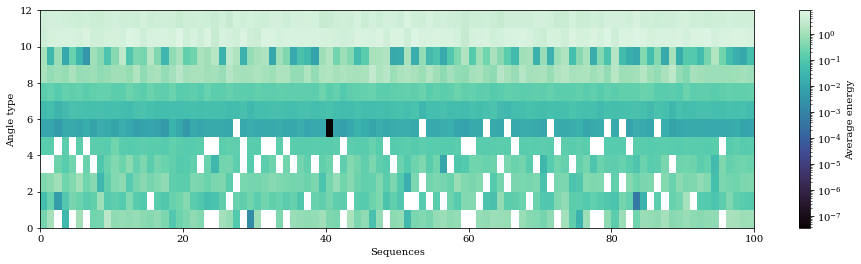

In [35]:
fig = plt.figure(figsize=(16,4))
data = out_angle_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Angle type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[4.02540857e-01 1.74888656e-01 9.04205190e-02 8.85224836e-02
 8.28451403e-02 7.36388845e-02 6.40783709e-02 1.90369558e-02
 2.98802689e-03 7.39137269e-04 2.24229126e-04 7.67395397e-05]


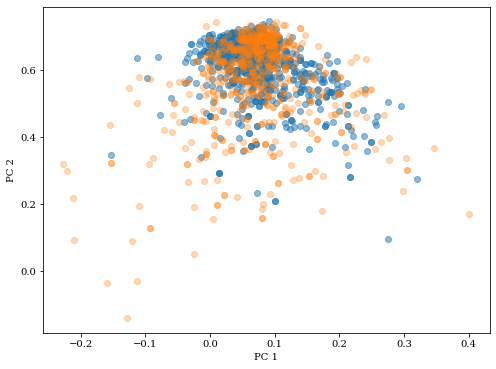

In [36]:
out_angles_pca = apca.transform(normalize(out_angle_matrix))
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out_angles_pca[angles_amber<amean,0], out_angles_pca[angles_amber<amean,1], alpha=0.5)
ax.scatter(out_angles_pca[angles_amber>=amean,0], out_angles_pca[angles_amber>=amean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(apca.explained_variance_ratio_)

In [37]:
out_torsion_matrix = torch.zeros(len(features),25)
for i in range(len(features)):
    out_torsion_matrix[i] = create_torsionmatrix_line(phis[i], coords[i], torsions[i],
                                                      out_torsion_pars, mult, out_dat_pars)

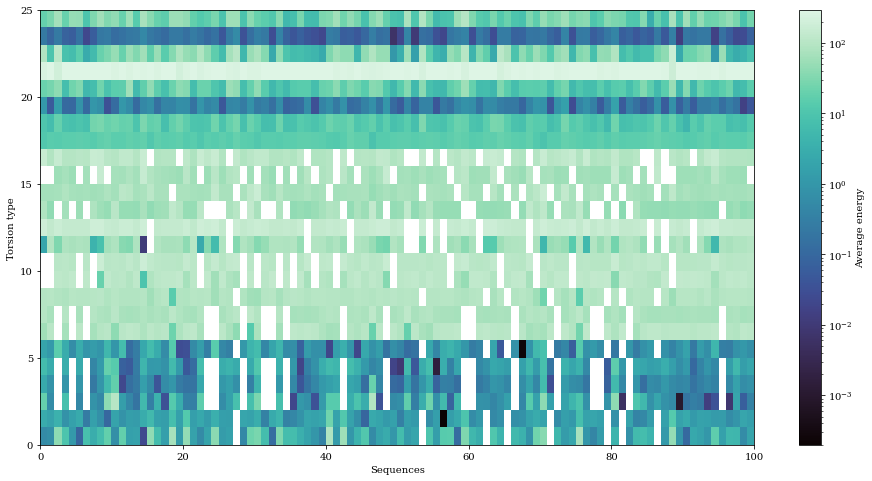

In [38]:
fig = plt.figure(figsize=(16,8))
data = out_torsion_matrix[:100].transpose(1,0)
heatmap = plt.pcolormesh(data, cmap="mako", norm=LogNorm())
cbar = plt.colorbar(heatmap)
plt.xlabel("Sequences")
plt.ylabel("Torsion type")
cbar.ax.set_ylabel("Average energy", rotation=90)
plt.show()

[3.12470931e-01 1.65464562e-01 1.25662726e-01 9.32908511e-02
 8.63306201e-02 5.11038323e-02 3.92082687e-02 3.23113436e-02
 2.57040873e-02 1.81223159e-02 1.07078360e-02 8.63315787e-03
 8.20572768e-03 6.96581963e-03 5.40376923e-03 4.33315369e-03
 3.62960862e-03 9.81231114e-04 8.67712648e-04 2.51651025e-04
 1.75011375e-04 1.51409452e-04 1.40282900e-05 1.02148573e-05
 1.30918520e-07]


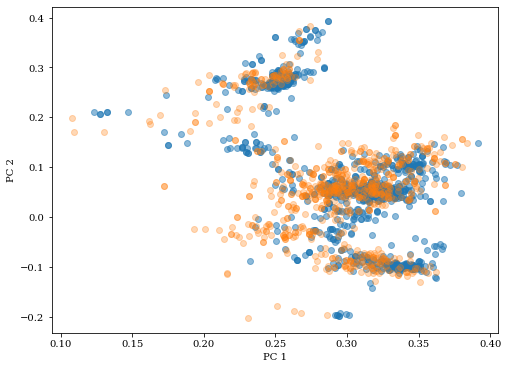

In [39]:
out_torsions_pca = tpca.transform(normalize(out_torsion_matrix))
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out_torsions_pca[torsions_amber<tmean,0], out_torsions_pca[torsions_amber<tmean,1], alpha=0.5)
ax.scatter(out_torsions_pca[torsions_amber>=tmean,0], out_torsions_pca[torsions_amber>=tmean,1], alpha=0.3)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

print(tpca.explained_variance_ratio_)